In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
from utility import analysis_parameters as ap, util
import numpy as np
import pandas as pd
import dask
# from dask.diagnostics import ProgressBar
# pbar = ProgressBar()
# pbar.register()

colors = ap.COLORS

# Plot accumulated precip 

In [2]:
models = ["GPM-IMERG", "SAM", "SCREAM", "UM", "IFS","ICON", "GEOS", "SHiELD", "ARP", "MPAS"]

In [3]:
# pr = xr.open_dataset(ap.get_fldmean_file("MPAS", "GT", "pr")).pr.isel(lat=0).isel(lon=0)
# # (pr-pr[0]).plot()
# pr

0 GPM-IMERG	<xarray.DataArray 'precipitation' (time: 1440)>
[1440 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-28T23:30:00
1 SAM	2 SCREAM	3 UM	4 IFS	5 ICON	6 GEOS	7 SHiELD	8 ARP	9 MPAS	

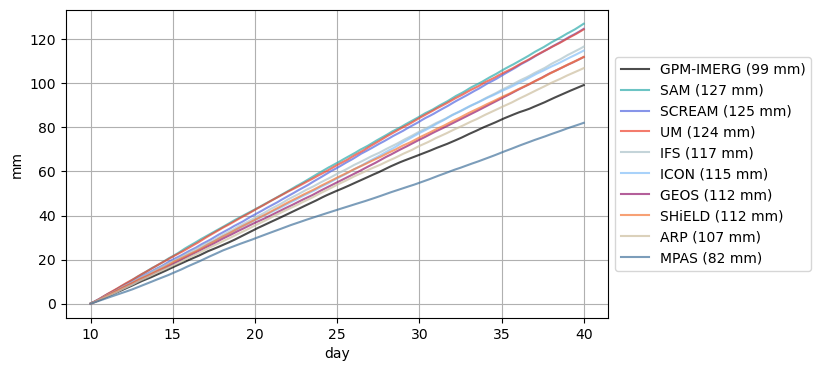

In [14]:
# plot accumulated precip of entire GT region (30N-30S)

fig, ax = plt.subplots(1,1, figsize=(7,4))

for i, m in enumerate(models):
    print(i, m, end="\t")
    if m=="GPM-IMERG":
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "precipitation")).precipitation
        print(pr)
    elif m=="ICON" or m=="IFS":
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pracc")).pracc
        pr = pr[:,0,0]
    else:
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pr")).pr
        pr = pr[:,0,0]
    # print(pr.shape, pr.time[0].values, pr.time[1].values)
    # pr = pr[:,0,0]
    if m=="ARP":
        pr = pr.cumsum(axis=0)
    elif m=="ICON" or m=="MPAS":
        pr = pr-pr[0]
    elif m=="IFS":
        pr = (pr-pr[0])*1000
    else:
        pr = pr.cumsum(axis=0)*900 # to get in mm (dt = 900s; 1m=1000mm)
    if m=="MPAS":
        time_array = np.linspace(0,30,len(pr.xtime))
    else:
        time_array = np.linspace(0,30,len(pr.time))
    if m=="SAM":
        pr = pr/3600
    elif m=="SCREAM":
        pr = pr*1000
    elif m=="GPM-IMERG":
        pr = pr/1800
    if m=="GPM-IMERG":
        cm = colors["OBS"]
    else:
        cm = colors[m]
    ax.plot(time_array+10, pr[:len(time_array)], color=cm, label="{} ({:.0f} mm)".format(m,(pr[len(time_array)-1].values)), linewidth=1.5, alpha=0.7)
ax.legend(loc=6, bbox_to_anchor=(1,0.5))
ax.grid(True)
# ax.set_title("Accumulated Precipitation - Global Tropics")
ax.set_ylabel("mm")
ax.set_xlabel("day")
plt.savefig("../plots/GT/pracc_30days.png", bbox_inches="tight", pad_inches=1, dpi=120)
plt.show()

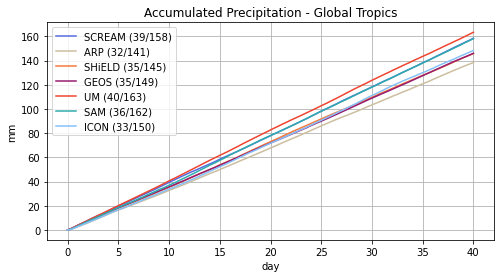

# percent of precip that is stratiform vs convective

stratiform precipitation is defined as less than 1 mm/hr


In [4]:
first_time = False
# pr = xr.open_dataset(ap.get_file("MPASr1deg", "GT", "pr")).pr
# (pr.mean(dim=["lat","lon"])).plot(label="MPAS")
# pr = xr.open_dataset(ap.get_file("IFSr1deg", "GT", "pr")).pr
# pr.mean(dim=["lat","lon"]).plot(label="IFS")
# pr = xr.open_dataset(ap.get_file("SCREAMr1deg", "GT", "pr")).pr
# pr.mean(dim=["lat","lon"]).plot(label="SCREAM")
# plt.legend()
# plt.show()

In [5]:
# np.prod(pr.shape), pr.shape, 2879*60*360

In [6]:
models = ["GPM-IMERG", "SAM", "SCREAM", "UM", "IFS","ICON", "GEOS", "SHiELD", "ARP", "MPAS"]

if first_time:
    # models = ["SAM", "IFS"] # test
    df = pd.DataFrame({"Data":np.array([0,0,0])}, index=["strat","conv","tot"])

    for i, m in enumerate(models):
        print(i, m[:3], end="\t")
        if m[:3]=="GPM":
            pr = xr.open_dataset("/scratch/b/b380883/GPM_3IMERG_precip_20200120-20200228.nc", 
                                 chunks={"time":400,"lat":300,"lon":300}).precipitation
        else:
            pr = xr.open_dataset(ap.get_file(m+"r1deg", "GT", "pr")).pr
        print(pr.shape)

        # convert to mm/hr
        pr_coeff = 3600
        pr=pr*pr_coeff
        strat = np.sum(pr.where(pr<1, 1, 0))
        conv = np.prod(pr.shape)-strat
        df[m] = np.array([strat, conv, np.prod(pr.shape)])
    df

In [7]:
# Save strat-conv ratios as a csv file
if first_time:
    df.to_csv("/work/bb1153/b380883/stats/GT/strat-conv-tot_precip.csv")

In [16]:
# load csv
if not(first_time):
    print("opening csv...")
    df = pd.read_csv("/work/bb1153/b380883/stats/GT/strat-conv-tot_precip.csv", index_col=0)
df.head()

opening csv...


,Data,GPM-IMERG,SAM,SCREAM,UM,IFS,ICON,GEOS,SHiELD,ARP,MPAS
strat,0,5.215047e+08,8420930.0,6960078.5,5909097.0,1380881.25,7642691.0,6320203.0,6338828.5,5440095.5,3610373.0
conv,0,3.632607e+09,53787070.0,55247921.5,56298903.0,14149518.75,53917309.0,55887797.0,55869171.5,56767904.5,58576027.0
tot,0,4.154112e+09,62208000.0,62208000.0,62208000.0,15530400.00,61560000.0,62208000.0,62208000.0,62208000.0,62186400.0


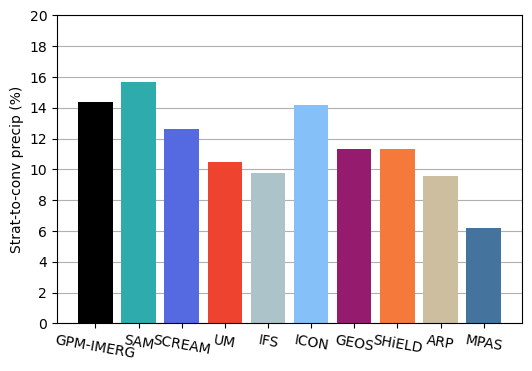

In [27]:
# plot fraction of stratiform to convective precipitation
fig, ax = plt.subplots(1,1,figsize=(6,4))
for i, m in enumerate(models):
    if m=="GPM-IMERG":
        cm="OBS"
    else:
        cm=m
    ax.bar(i+0.5, df[m].strat/df[m].conv*100, color=colors[cm])

ax.set_xticks(ticks=np.arange(0.5,len(models)), labels=models)
ax.grid(axis='y')
ax.set(ylim=[0,20], yticks=np.arange(0,21,2), axisbelow=True)
ax.tick_params(axis='x', labelrotation=-10)
plt.ylabel("Strat-to-conv precip (%)")
plt.savefig("../plots/GT/strat_conv_pr.png")
plt.show()

# PR pdf

In [10]:
models = ["SAM", "SCREAM", "UM", "IFS","ICON", "GEOS", "SHiELD", "ARP", "MPAS"]

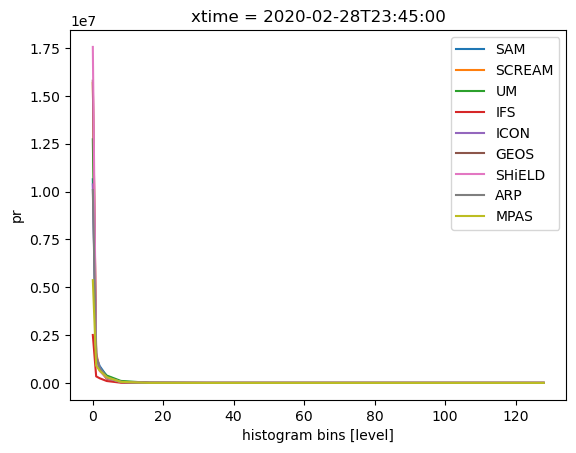

In [12]:
for m in models:
    ds = xr.open_dataset(ap.GT+"stats/histcount_GT_{}r1deg_pr_20200130-20200228.nc".format(m))
    ds = ds.sum(dim=["lat","lon"])
    ds.pr.plot(label=m)
plt.legend()
plt.show()

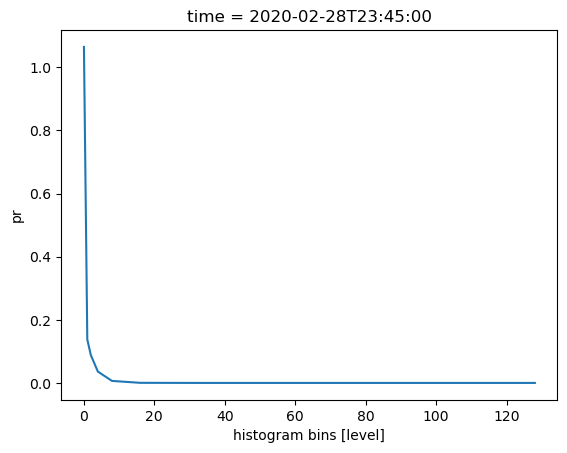

In [6]:
(ds.pr/1e7).plot()


# Land vs ocean precipitation 

GEOS has an ocean/land fraction in the grid file located here: ```/work/ka1081/DYAMOND-WINTER/NASA/GEOS-3km/DW-ATM/atmos/fx/sftlf/r1i1p1f1/ml/gn/sftlf_fx_GEOS-3km_DW-ATM_r1i1p1f1_ml_gn_fx.nc``` which has been regridded and subset here: ```/work/bb1153/b380883/GT/GT_land-fraction-map-from-GEOSr1deg.nc```

[########################################] | 100% Completed | 101.07 ms
[########################################] | 100% Completed | 201.22 ms


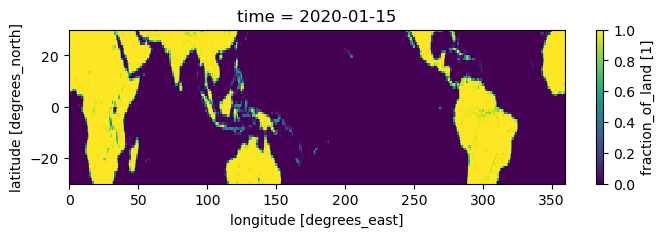

In [7]:
ds = xr.open_dataset("/work/bb1153/b380883/GT/GT_land-fraction-map-from-GEOSr1deg.nc",
                    chunks={'Xdim':36000}).sftlf.isel(time=0)
ds.plot.pcolormesh(figsize=(8,2))
plt.show()

In [ ]:
# plot accumulated precip of land vs ocean from 30N-30S
# land must be 1 deg of all land; ocean is 1 deg of all ocean
# in file land=1; ocean=0

fig, ax = plt.subplots(1,1, figsize=(6,3))

for i, m in enumerate(models):
    print(i, m, end="\t")
    if m=="ICON":
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pracc")).pracc
    else:
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pr")).pr
    print(pr.shape, pr.time[0].values, pr.time[1].values)
    pr = pr[:,0,0]
    if m=="ARP":
        pr = pr.cumsum(axis=0)
    elif m=="ICON":
        pr = pr-pr[0]
    elif m!="ICON":
        pr = pr.cumsum(axis=0)*900 # to get in mm (dt = 900s; 1m=1000mm)
    time_array = np.linspace(0,30,len(pr.time))
    if m=="SAM":
        pr = pr/3600
    elif m=="SCREAM":
        pr = pr*1000
    ax.plot(time_array+10, pr[:len(time_array)], color=colors[m], label=m, linewidth=1)
ax.legend()
ax.grid(True)
ax.set_title("Accumulated Precipitation - Global Tropics")
ax.set_ylabel("mm")
ax.set_xlabel("day")
plt.savefig("../plots/GT/pracc_30days.png")
plt.show()

## Diurnal cycle of precipitation (UTC)


In [53]:
models = ["UM", "SAM", "SCREAM", "ARP","GEOS","ICON","SHiELD"]
models = ["SCREAM","SAM","UM","ARP","GEOS","ICON"]

0 SCREAM	(2976, 1, 1) 2020-01-30 00:00:00 2020-01-30 00:15:00
1 SAM	(2975, 1, 1) 2020-01-30T00:15:00.000000000 2020-01-30T00:30:00.000000000
2 UM	(2880, 1, 1) 2020-01-30T00:07:30.000000000 2020-01-30T00:22:30.000000000
3 ARP	(2880, 1, 1) 2020-01-30T00:00:00.000000000 2020-01-30T00:15:00.000000000
4 GEOS	(2880, 1, 1) 2020-01-30T00:00:00.000000000 2020-01-30T00:15:00.000000000
5 ICON	(2849, 1, 1) 2020-01-30T00:30:00.000000000 2020-01-30T00:45:00.000000000


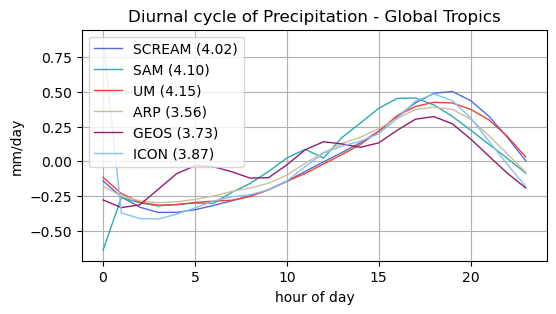

In [57]:
# plot diurnal cycle of precipitation
fig, ax = plt.subplots(1,1, figsize=(6,3))

for i, m in enumerate(models):
    print(i, m, end="\t")
    if m=="ICON":
        pracc = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pracc")).pracc
        pr = (pracc[1:,:,:]-pracc[:-1,:,:].values)/900
    elif m=="ARP":
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pr")).pr/900*3600*24 # mm -> mm/day
    else:
        pr = xr.open_dataset(ap.get_fldmean_file(m, "GT", "pr")).pr
    print(pr.shape, pr.time[0].values, pr.time[1].values)
    pr = pr[:,0,0]
    pr_diurnal = pr.groupby(pr.time.dt.hour).mean()-pr.mean()
    if m=="SAM":
        pr_coeff = 24
    elif m=="SCREAM":
        pr_coeff = 3600*1000*24
    elif m=="UM" or m=="GEOS" or m=="ICON" or m=="SHiELD":
        pr_coeff = 3600*24
    else:
        pr_coeff = 1
    
    # convert to mm/day
    pr_diurnal= pr_diurnal*pr_coeff
    pr_mean = pr.mean()*pr_coeff
    # plot
    ax.plot(np.arange(0,24), pr_diurnal, color=colors[m], 
            label=m+" ({:.2f})".format(pr_mean), linewidth=1)
ax.legend()
ax.grid(True)
ax.set_title("Diurnal cycle of Precipitation - Global Tropics")
ax.set_ylabel("mm/day")
ax.set_xlabel("hour of day")
plt.savefig("../plots/GT/pr_diurnalcycle.png")
plt.show()

<xarray.DataArray 'pr' (time: 2880, lat: 1, lon: 1)>
[2880 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2020-01-30 ... 2020-02-28T23:45:00
  * lon      (lon) float64 0.0
  * lat      (lat) float64 0.0
Attributes:
    standard_name:  precipitation_flux
    long_name:      surface precipitation rate [kg/m**2/s]
    units:          kg m-2 s-1
    cell_methods:   time: point


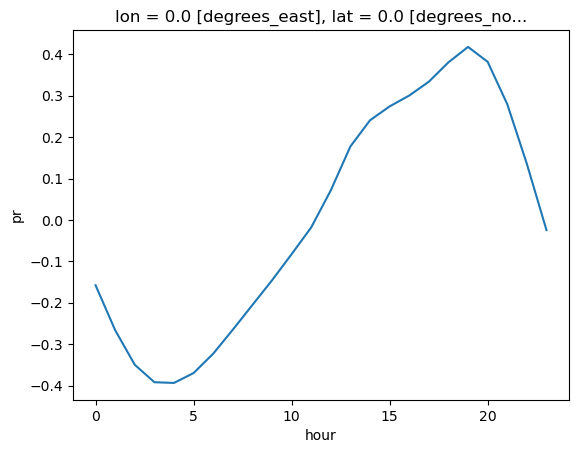

In [56]:
# single model
pr = xr.open_dataset(ap.get_fldmean_file("SHiELD", "GT", "pr")).pr
# pr = (pr[1:,:,:]-pr[:-1,:,:].values)/900
print(pr)
pr = pr[:,0,0]
pr_diurnal = pr.groupby(pr.time.dt.hour).mean()-pr.mean()
(pr_diurnal*3600*24).plot()

# Other

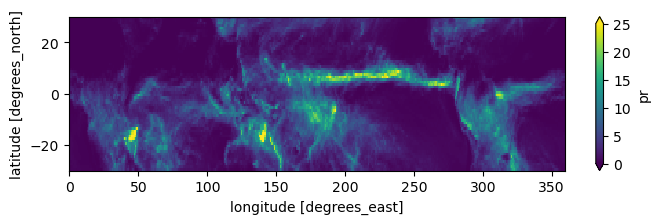

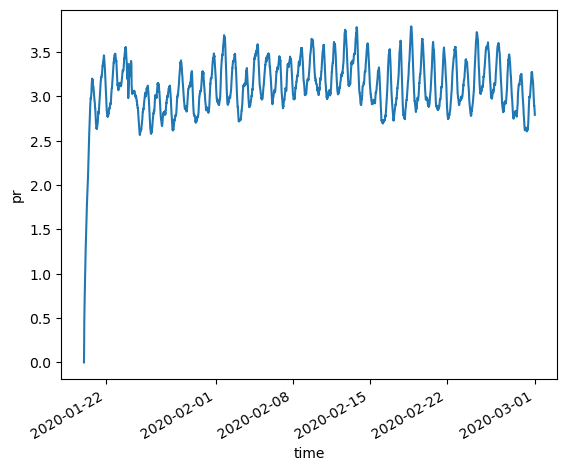

In [8]:
pr = xr.open_dataset(ap.GT+"GT_ARPr1deg_pr_20200120-20200228.nc").pr
# pr = pr.where(pr.time.dt.hour!=0)
(pr.mean(axis=0)*3600*24/1000).plot(figsize=(8,2), vmin=0, vmax=25)
plt.show()
(pr.mean(axis=(1,2))*3600*24/1000).plot()
plt.show()


In [34]:
# pr.to_netcdf(ap.GT+"GT_ICONr1deg_pr_20200120-20200228_fixed.nc")

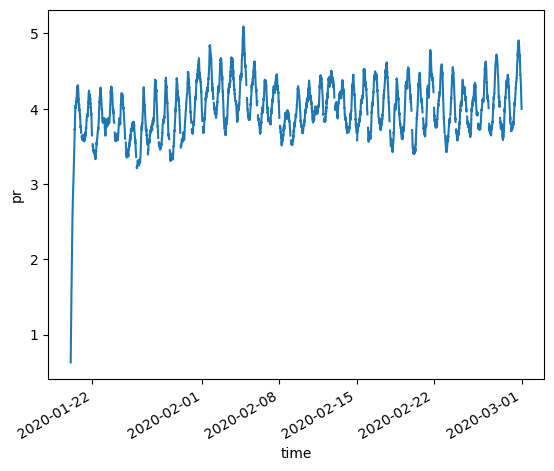

In [32]:
ds = xr.open_dataset(ap.GT+"GT_SAMr1deg_pr_20200120-20200228.nc")
pr = ds.where(ds.time.dt.hour!=0).pr
pr[3191] = np.nan
pr[3311] = np.nan
pr[3503] = np.nan
pr[3695] = np.nan

# (pr.mean(axis=0)*3600*24).plot(figsize=(8,2))
# plt.show()
(pr.mean(axis=(1,2))*3600*24).plot()
# plt.show()


In [33]:
ds_new = xr.Dataset({"pr":pr}, attrs=ds.attrs)
ds_new

<xarray.Dataset>
Dimensions:  (time: 3934, lon: 360, lat: 60)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:30:00 ... 2020-02-29T23:45:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
Data variables:
    pr       (time, lat, lon) float32 nan nan nan nan nan ... 0.0 0.0 0.0 0.0
Attributes:
    CDI:                       Climate Data Interface version 2.2.4 (https://...
    Conventions:               CF-1.6
    history:                   Thu Oct 26 00:11:49 2023: cdo -setname,pr -set...
    NCO:                       netCDF Operators version 4.9.3 (Homepage = htt...
    cdo_openmp_thread_number:  8
    CDO:                       Climate Data Operators version 2.2.2 (https://...

In [34]:
ds_new.to_netcdf(ap.GT+"GT_SAMr1deg_pr_20200120-20200228_fixed.nc")